# Trabajo práctico N°2 - Regresión polinómica.

# Exploración de datos.

In [1]:
#librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### Se definen los conjuntos de entrenamiento, testeo y validación.

In [2]:

#se cargan los datos del csv
df = pd.read_csv('car_data.csv')

#Se eliminan del df las columnas Car_Name y Owner
df.drop('Car_Name', axis=1, inplace=True)  #Se modifica el df en sí, no genera una copia.
df.drop('Owner', axis=1, inplace=True) 

#Se definen los conjuntos de entrenamiento, testeo y validación, se crean copias del df original
train = df[df['Set'] == 'Train'].copy()
test = df[df['Set'] == 'Test'].copy()
validation = df[df['Set'] == 'Validation'].copy()

#Se elimina la columna Set del df original y de los conjuntos previos
df.drop('Set', axis=1, inplace=True)
train.drop('Set', axis=1, inplace=True)
test.drop('Set', axis=1, inplace=True)
validation.drop('Set', axis=1, inplace=True)


##### Se calculan las proporciones de las variables categóricas, representando las probabilidades de cada una.

In [3]:
#Se calculan las probabilidades para los tipos de combustible (Fuel_Type)
prob_fuel_type = df['Fuel_Type'].value_counts(normalize=True)

#Se calculan las probabildiades para lso tipos de vendedores (Seller_Type)
prob_seller_type = df['Seller_Type'].value_counts(normalize=True)

#Se calculan las probabilidades de los tipos de transmisiones (Transmission)
prob_transmission_type = df['Transmission'].value_counts(normalize=True)

print('Probabilidades de',prob_fuel_type,'\n')
print('Probabilidades de',prob_seller_type,'\n')
print('Probabilidades de',prob_transmission_type,'\n')

Probabilidades de Fuel_Type
Petrol    0.794020
Diesel    0.199336
CNG       0.006645
Name: proportion, dtype: float64 

Probabilidades de Seller_Type
Dealer        0.647841
Individual    0.352159
Name: proportion, dtype: float64 

Probabilidades de Transmission
Manual       0.86711
Automatic    0.13289
Name: proportion, dtype: float64 



# Pre-procesamiento.

In [4]:
#librerias se scikit-learn
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

##### Codificación.

In [ ]:
#Se genera el encoder para cada una de las variables categóricas binarias y no binarias
encoder_transmission = OneHotEncoder(sparse_output=False, drop = 'if_binary')
encoder_seller = OneHotEncoder(sparse_output=False, drop = 'if_binary')
encoder_fuel = OneHotEncoder(sparse_output=False, drop = 'if_binary')

#Se codifican las variables categóricas para los datos de entrenamiento
transmission_train = encoder_transmission.fit_transform(train[['Transmission']])
seller_train = encoder_seller.fit_transform(train[['Seller_Type']])
fuel_train = encoder_fuel.fit_transform(train[['Fuel_Type']])


#Se repite el mismo procedimiento para los datos de validación y testeo
# ------ Validación
#Se aplica solo transform, ya que el modelo no debe tener información desconocida en el training
transmission_val = encoder_transmission.transform(validation[['Transmission']])
seller_val = encoder_seller.transform(validation[['Seller_Type']])
fuel_val = encoder_fuel.transform(validation[['Fuel_Type']])

# ------ Testeo
transmission_test = encoder_transmission.transform(test[['Transmission']])
seller_test = encoder_seller.transform(test[['Seller_Type']])
fuel_test = encoder_fuel.transform(test[['Fuel_Type']])

#Se imprimen las categorías para ver el orden de las mismas tras la codificación
print(encoder_fuel.categories_)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

##### Mapa polinómico.

In [ ]:
#Se seleccionan las columnas con valores numéricos: se quitan las variables categóricas y el precio de venta.
values_train = train.drop(columns = ['Selling_Price','Transmission','Seller_Type','Fuel_Type' ])
values_val = validation.drop(columns=['Selling_Price','Transmission','Seller_Type','Fuel_Type'])
values_test = test.drop(columns=['Selling_Price','Transmission','Seller_Type','Fuel_Type'])

#Se crea el mapa polinómico de grado 3, sin incluir la columna de 1's
poly = PolynomialFeatures(degree=3, include_bias=False)
values_train_poly = poly.fit_transform(values_train)
values_val_poly = poly.transform(values_val) #Solo se transforma ya que se hace el fit con los datos de entrenamiento
values_test_poly = poly.transform(values_test) #Solo se transforma ya que se hace el fit con los datos de entrenamiento

#Se realiza una normalización de los valores del mapa polinómico.
scaler = StandardScaler()   
train_poly_norm = scaler.fit_transform(values_train_poly)   #Se realiza el fit solo con los datos de entrenamiento
val_poly_norm = scaler.transform(values_val_poly)   #Solo se transforma ya que se hace el fit con los datos de entrenamiento
test_poly_norm = scaler.transform(values_test_poly) #Solo se transforma ya que se hace el fit con los datos de entrenamiento

#Se concatenan todos los datos en un array de numpy
train_combined = np.c_[
    train_poly_norm,
    transmission_train,
    seller_train,
    fuel_train
]

val_combined = np.c_[
    val_poly_norm,
    transmission_val,
    seller_val,
    fuel_val
]

test_combined = np.c_[
    test_poly_norm,
    transmission_test,
    seller_test,
    fuel_test
]

# Regresión Lineal.

In [ ]:
#Se define la regresión lineal para utilizarla por separado
regressor  = LinearRegression(fit_intercept=True)

#------------- Se crea el pipeline completo
#Se definen las variables categóricas y numéricas
categorical_features = ['Transmission','Seller_Type','Fuel_Type'] #Binarias y no binarias
numeric_features = ['Year','Present_Price','Kms_Driven'] #Exceptuando el precio de venta

#Se define el pipeline para el preprocesamiento de las variables numéricas
pipeline_num = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),    #Mapa polinómico
    ('normalizator', StandardScaler()),    #Normalización
])

#Se define el preprocesador: OneHotEncoder para las categóricas y el pipeline_num para las numéricas
preprocessor = ColumnTransformer(transformers = [
    ('cat', OneHotEncoder(drop="if_binary"), categorical_features),   #Codificación de las categóricas
    ('num', pipeline_num, numeric_features) #Preprocesamiento de las numéricas
])

#Se define el pipeline completo, incluyendo preprocesador y regresor
pipeline = Pipeline([
    ('preprocessor', preprocessor), #Preprocesamiento para las distintas variables
    ('regressor', LinearRegression(fit_intercept=True)) #Regresor lineal
])


##### Entrenamiento del sistema.

In [ ]:
#Se selecciona la variable a predecir para los conjuntos de datos
y_train = train['Selling_Price'].values
y_val = validation['Selling_Price'].values
y_test = test['Selling_Price'].values

#Se entrena el modelo
regressor.fit(train_combined, y_train)

#Se entrena el modelo utilizando el pipeline completo
pipeline.fit(train,y_train)


# #Coeficientes
# lr_model = regressor
# print("Coeficientes:", lr_model.coef_.shape)

display(pipeline)

reg = pipeline.named_steps['regressor']
print('Cantidad de parámetros en total: ', reg.coef_.shape[0]+1) #Se imprime la cantidad de parámetros del modelo

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Cantidad de parámetros en total:  25


##### El modelo tiene 25 parámetros debido a que: 5 provienen de las variables categóricas, 3 provienen de las variables numéricas. Luego, hay 16 que provienen del mapa polinómico de grado 3 construido a partir de las variables numéricas y por último el bias.

##### Predicción y errores.

In [ ]:
#Se realiza la predicción para los datos de entrenamiento y de validación
y_train_pred = regressor.predict(train_combined)
y_val_pred = regressor.predict(val_combined)

#Se realiza la predicción para los datos de entrenamiento y de validación utilizando el pipeline completo
y_train_pred_pipe = pipeline.predict(train)
y_val_pred_pipe = pipeline.predict(validation)

#Se calcula el MSE de entrenamiento y de validación
mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)

mse_train_pipe = mean_squared_error(y_train, y_train_pred_pipe)
mse_val_pipe = mean_squared_error(y_val, y_val_pred_pipe)

print('Error de entrenamiento:',round(mse_train,2))
print('Error de validación:',round(mse_val,2))

print('Error de entrenamiento con el pipeline completo:',round(mse_train_pipe,2))
print('Error de validación con el pipeline completo:',round(mse_val_pipe,2))



Error de entrenamiento: 0.47
Error de validación: 0.54
Error de entrenamiento con el pipeline completo: 0.47
Error de validación con el pipeline completo: 0.54


# Regularización.

In [ ]:
#librerias
from sklearn.linear_model import Ridge

##### Regresión Polinómica Regularizada.

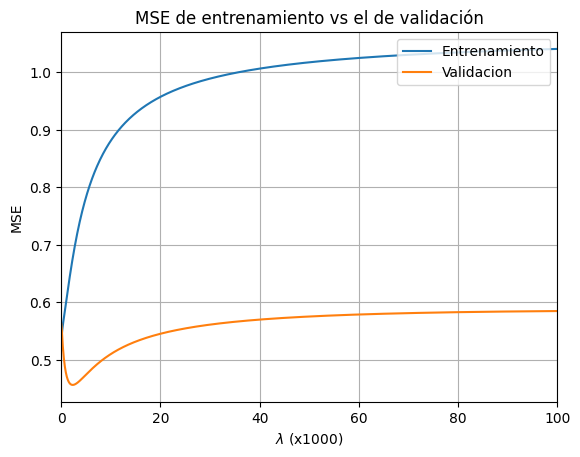

In [ ]:
pipeline_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

#Se genera el array de lambdas en el intervalo dado
lambda_min=1e-6
lambda_max=1e-2
n_samples = 1000
lambda_array = np.linspace(lambda_min, lambda_max, n_samples)

#Se generan listas vacías para cargar los valores MSE de entrenamiento y validación
mse_train_list = []
mse_val_list = []

for alpha in lambda_array:
    #Se actualiza el parámetro de ridge
    pipeline_reg.set_params(ridge__alpha=alpha)
    
    #Se realiza el entrenamiento con el nuevo parámetro
    pipeline_reg.fit(train, y_train)
    
    #Se realizan las predicciones
    y_train_pred = pipeline_reg.predict(train)
    y_val_pred   = pipeline_reg.predict(validation)
    
    #Se cargan los MSE en las listas
    mse_train_list.append(mean_squared_error(y_train, y_train_pred))
    mse_val_list.append(mean_squared_error(y_val, y_val_pred))

plt.plot(lambda_array*10000, mse_train_list,label = 'Entrenamiento')
plt.plot(lambda_array*10000, mse_val_list,label = 'Validacion')
plt.title('MSE de entrenamiento vs el de validación')
plt.legend(loc = 'upper right')
plt.ylabel('MSE')
plt.xlabel(r'$\lambda$ (x1000)')
plt.xlim(0,100)
plt.grid()
plt.show()

##### Se calcula el MSE de testeo para el $\lambda$ minimo de validación

In [ ]:
#Se obtiene el lambda que produce el minimo MSE para los datos de validación
index_min_mse_val = np.argmin(mse_val_list)
lambda_min_val = lambda_array[index_min_mse_val]

print('Lambda que minimiza el MSE de validación:', round(lambda_min_val,5))

#Se coloca el parámetro de ridge
pipeline_reg.set_params(ridge__alpha=lambda_min_val)
    
#Se realiza el entrenamiento con el nuevo parámetro
pipeline_reg.fit(train, y_train)
    
#Se realiza la predicción para los datos de testeo
y_test_pred = pipeline_reg.predict(test)

#Se calcula el MSE para los datos de testeo
print('MSE para el lambda que minimiza el error de validación: ',round(mean_squared_error(y_test, y_test_pred),2))

Lambda que minimiza el MSE de validación: 0.00023
MSE para el lambda que minimiza el error de validación:  0.34
